# Data Science Essentials: GeoPandas
## October 4th, 2022
### Overview: Implementing GeoPandas to handle and plot geographic data

In [1]:
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from matplotlib import animation
from IPython.display import HTML
%matplotlib inline

## Problem 1

Read in the file *airports.csv* as a pandas dataframe.
Create three convex hulls around the three sets of airports listed below.
This can be done by passing in lists of the airports' coordinates to a *shapely.geometry.Polygon* object.

1. Maio Airport, Scatsta Airport, Stokmarknes Skagen Airport, Bekily Airport, K. D. Matanzima Airport, RAF Ascension Island
2. Oiapoque Airport, Maio Airport, Zhezkazgan Airport, Walton Airport, RAF Ascension Island, Usiminas Airport, Piloto Osvaldo Marques Dias Airport
3. Zhezkazgan Airport, Khanty Mansiysk Airport, Novy Urengoy Airport, Kalay Airport, Biju Patnaik Airport, Walton Airport
	
Create a new GeoDataFrame with these three Polygons as entries.
Plot this GeoDataFrame on top of an outlined world map.

In [3]:
first_set = ['Maio Airport', 'Scatsta Airport', 'Stokmarknes Skagen Airport',
                 'Bekily Airport','K. D. Matanzima Airport', 'RAF Ascension Island']
second_set = ['Oiapoque Airport','Maio Airport', 'Zhezkazgan Airport',
                'Walton Airport','RAF Ascension Island','Usiminas Airport',
                 'Piloto Osvaldo Marques Dias Airport']
third_set = ['Zhezkazgan Airport','Khanty Mansiysk Airport','Novy Urengoy Airport',
                 'Kalay Airport','Biju Patnaik Airport','Walton Airport']

In [4]:
#read in airports, create shapely points at coords, cast as gpd df
ap = pd.read_csv('airports.csv')
ap['Coordinates'] = list(zip(ap.Longitude, ap.Latitude))
ap['Coordinates'] = ap.Coordinates.apply(Point)
ap = gpd.GeoDataFrame(ap, geometry='Coordinates')

In [5]:
#get each set's list of coordinates
first_set_coords = ap.loc[ap['Name'].isin(first_set)]['Coordinates'].values
second_set_coords = ap.loc[ap['Name'].isin(second_set)]['Coordinates'].values
third_set_coords = ap.loc[ap['Name'].isin(third_set)]['Coordinates'].values

#getting convex hull
P1 =  first_set_coords.unary_union().convex_hull
P2 = second_set_coords.unary_union().convex_hull
P3 =  third_set_coords.unary_union().convex_hull

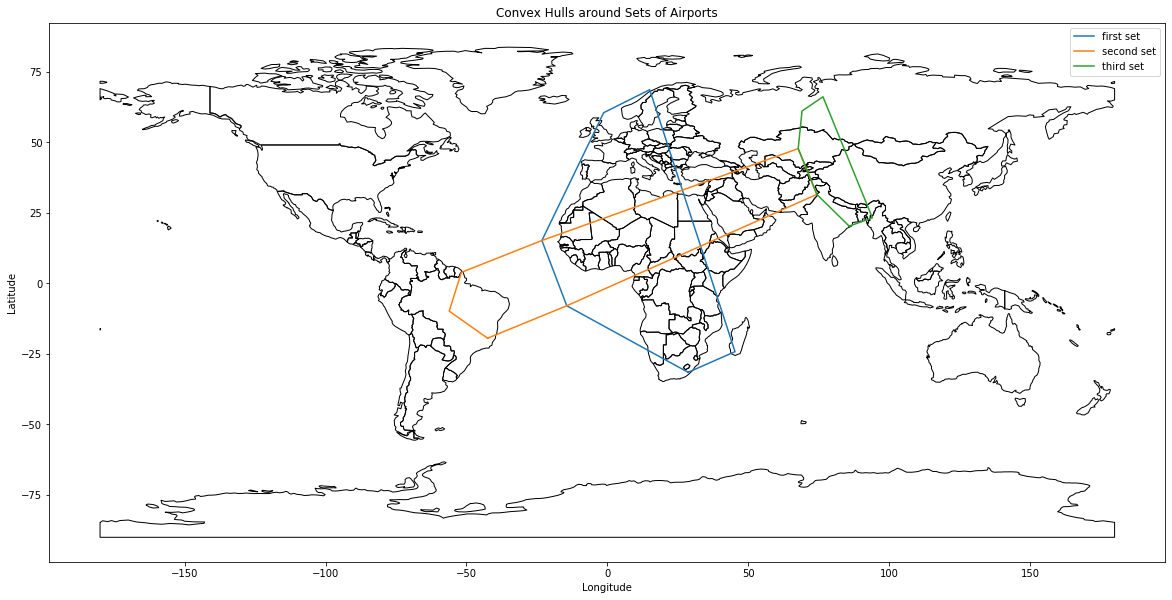

In [6]:
#PLOTTING WORLD AND CONVEX HULLS
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig,ax = plt.subplots(figsize=(20,40), ncols=1, nrows=1)
base = world.boundary.plot(edgecolor='black', ax=ax, linewidth=1)
plt.plot(*P1.exterior.xy,label = 'first set')
plt.plot(*P2.exterior.xy,label = 'second set')
plt.plot(*P3.exterior.xy,label = 'third set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title("Convex Hulls around Sets of Airports")
plt.legend()
plt.show()

## Problem 2
Use the command *geopandas.read_file('county_data.gpkg')* to create a GeoDataFrame of information about US counties.
Each county's shape is stored in the *geometry* column.
Use this to **plot the outlines of all US counties two times**, first using the default CRS and then using EPSG:5071.

Next, create a new GeoDataFrame that combines all counties within a single state.
Drop states with the following STATEFP codes: 02, 15, 60, 66, 69, 72, 78.
Plot this GeoDataFrame to see an outline of the 48 contiguous states.
Ensure a CRS of 5071.

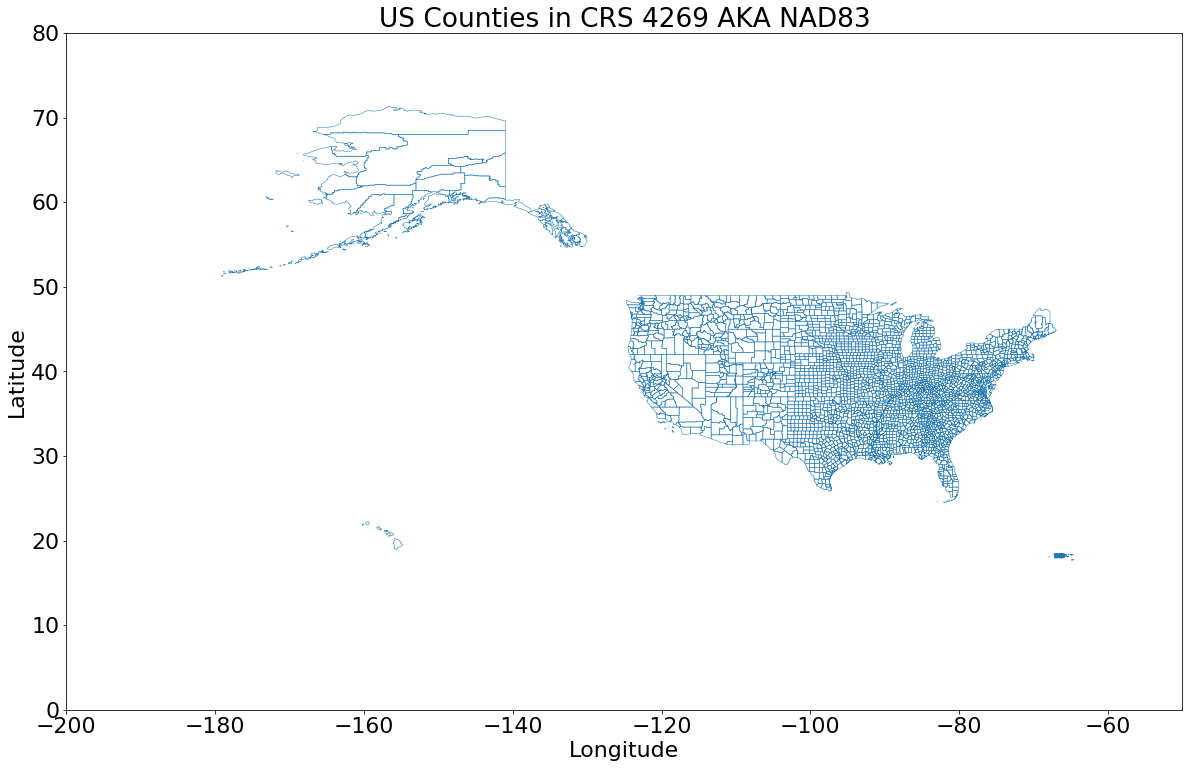

In [7]:
#read in county
county = gpd.read_file('county_data.gpkg')
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (20,20) #make plots big

#plot counties with default crs
county.boundary.plot(linewidth=0.5)
plt.title('US Counties in CRS 4269 AKA NAD83')
plt.xlim(-200,-50)
plt.ylim(0,80)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

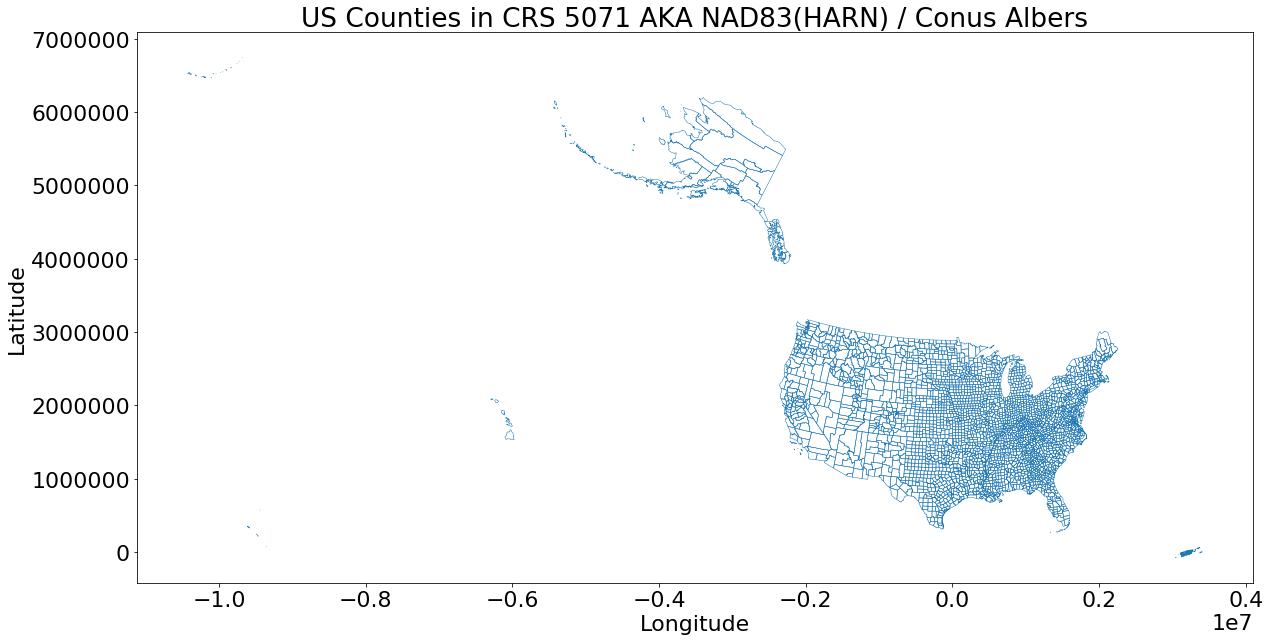

In [8]:
#other crs
county.to_crs(5071,inplace=True)
county.boundary.plot(linewidth=0.5)
plt.title('US Counties in CRS 5071 AKA NAD83(HARN) / Conus Albers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [9]:
#copy county, drop entries with certain statefp codes
county_copy = county.copy()
inds = []
for fp in ['02', '15', '60', '66', '69', '72', '78']:
    inds += list(county.loc[county_copy['STATEFP'] == fp].index)
county_copy.drop(inds,inplace=True)

In [10]:
#merge along statefp
states = county_copy.dissolve(by='STATEFP')

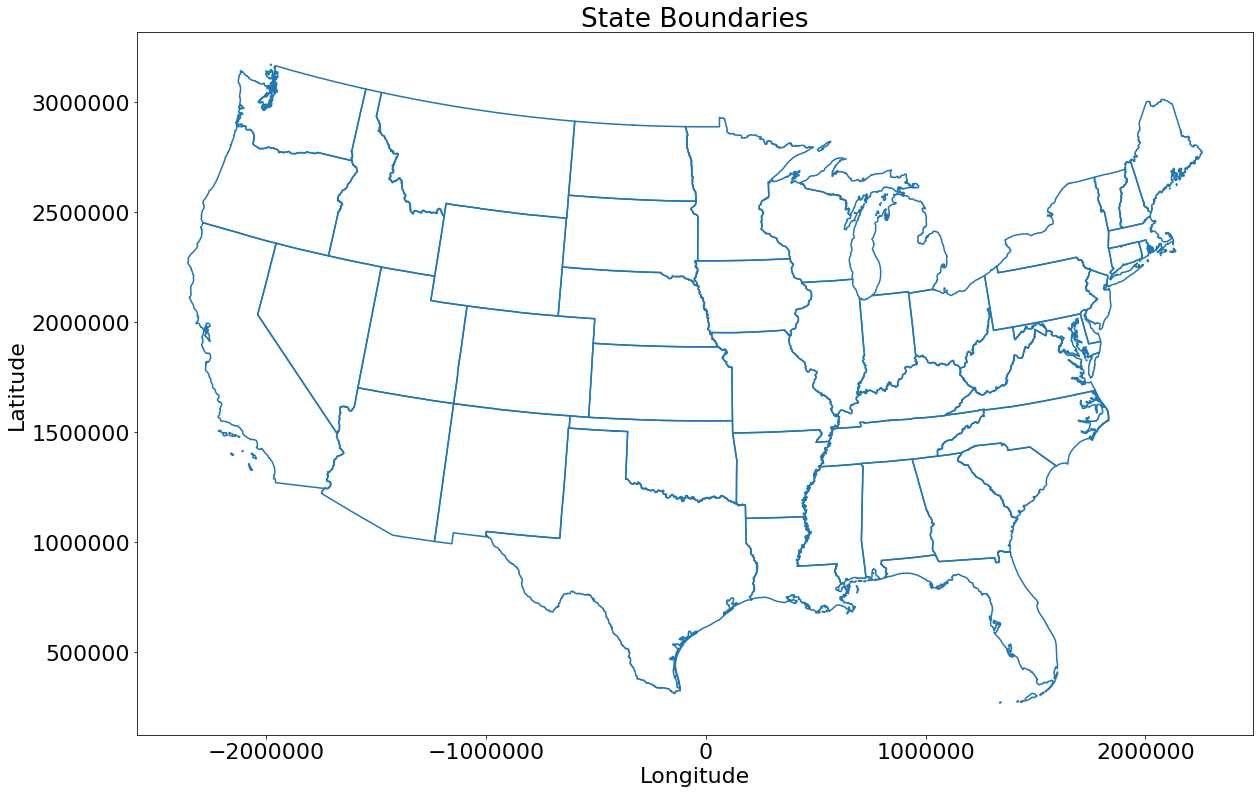

In [11]:
base = states.boundary.plot()
plt.title('State Boundaries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Problem 3

Load in the file *nytimes.csv* as a DataFrame.
This file includes county-level data for the cumulative cases and deaths of Covid-19 in the US, starting with the first case in Snohomish County, Washington, on January 21, 2020.
**First, convert the *date* column into a *DatetimeIndex*.**

Next, use county FIPS codes to **merge your GeoDataFrame from the previous problem with the DataFrame you just created.**
A FIPS code is a 5-digit unique identifier for geographic locations.
For this lab, we will not use rows in the Covid-19 DataFrame with unknown FIPS codes.
Also, we will just be examining data from the contiguous US, so **drop all data from Hawaii and Alaska and rows with unknown FIPS codes.**

Note that the *fips* column of the Covid-19 DataFrame stores entries as floats, but the county GeoDataFrame stores FIPS codes as strings, with the first two digits in the *STATEFP* column and the last three in the *COUNTYFP* column.

**Plot the cases from March 21, 2020 on top of your state outline map from the previous problem.
Finally, print out the name of the county with the most cases on March 21, 2020 along with its case count.**

In [12]:
#read in file
nyt = pd.read_csv('nytimes.csv')

In [13]:
#fips is statefp and countyfp concatenated
county['fips'] = county['STATEFP'] + county['COUNTYFP']
#cast to numeric for merging
county['fips'] = pd.to_numeric(county['fips'])
#merge on fips
nyt_county = nyt.merge(county,on='fips')

#get rid of hawaii and alaska, the worthless states
inds = []
for state in ['Hawaii','Alaska']:
    inds += list(nyt_county.loc[nyt_county['state'] == state].index)
nyt_county.drop(inds,inplace=True)

#convert date column to date time index
nyt_county.set_index(pd.to_datetime(nyt_county['date']),inplace=True)
nyt_county.drop(columns='date',inplace=True)

#make into gdf
nyt_county = gpd.GeoDataFrame(nyt_county, geometry='geometry')

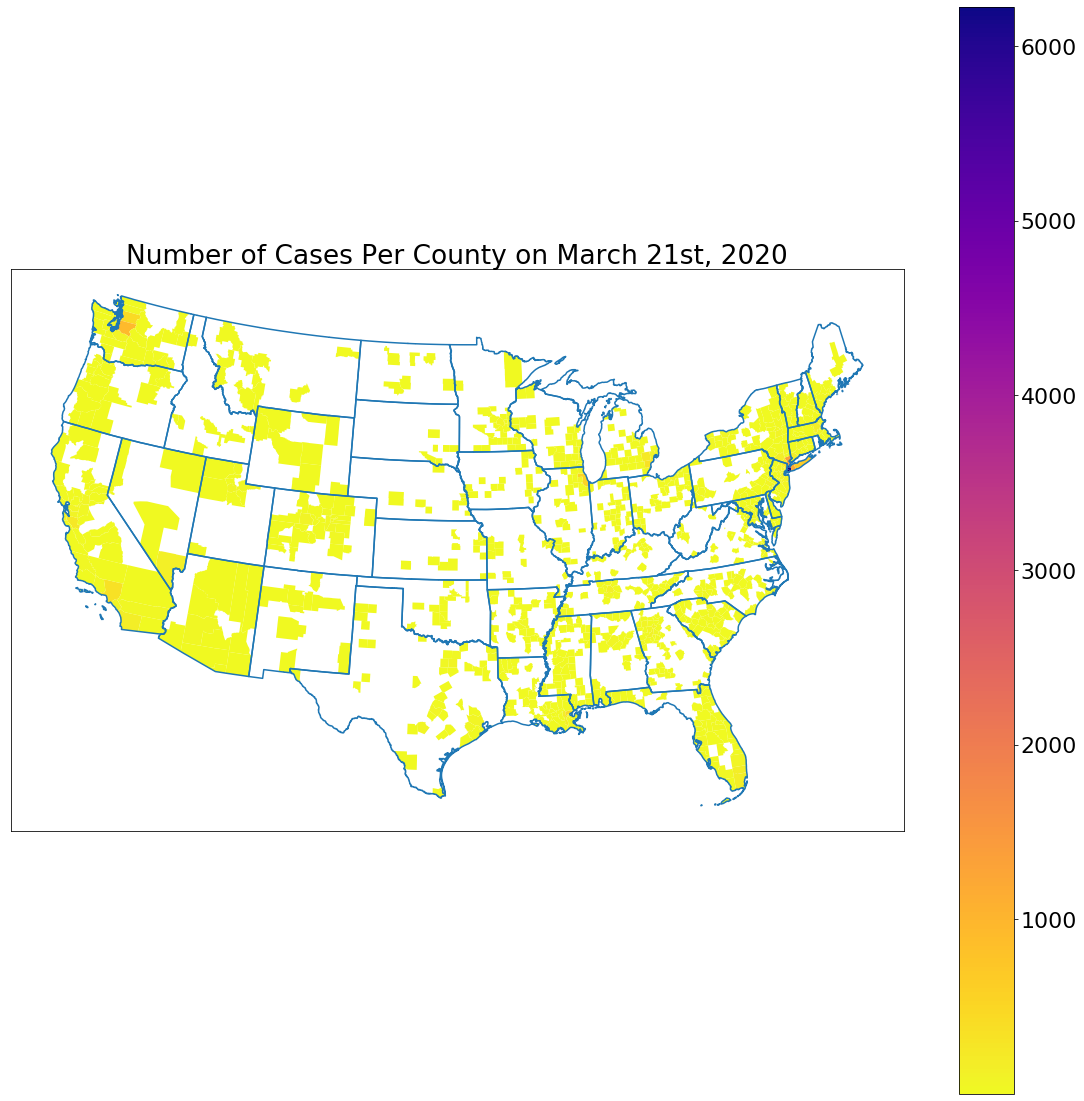

In [14]:
#state boundaries
base = states.boundary.plot()
#plot data
nyt_county.loc['2020-03-21'].plot(ax=base,column='cases',cmap='plasma_r',legend=True)
#labels
plt.xticks([])
plt.yticks([])
plt.title('Number of Cases Per County on March 21st, 2020')
plt.show()

In [15]:
#printing county name with most cases on march 21st, 2020
maxind = np.argmax(nyt_county.loc['2020-03-21']['cases'])
print(nyt_county.loc['2020-03-21'].iloc[maxind]['county'], np.max(nyt_county.loc['2020-03-21']['cases']))

New York City 6226


## Problem 4

As in Problem 3, plot your state outline map together with a map of Covid-19 cases from March 21, 2020.
This time, use a log scale.
Use EPSG:5071.
Pick a good colormap and be sure to display a colorbar.

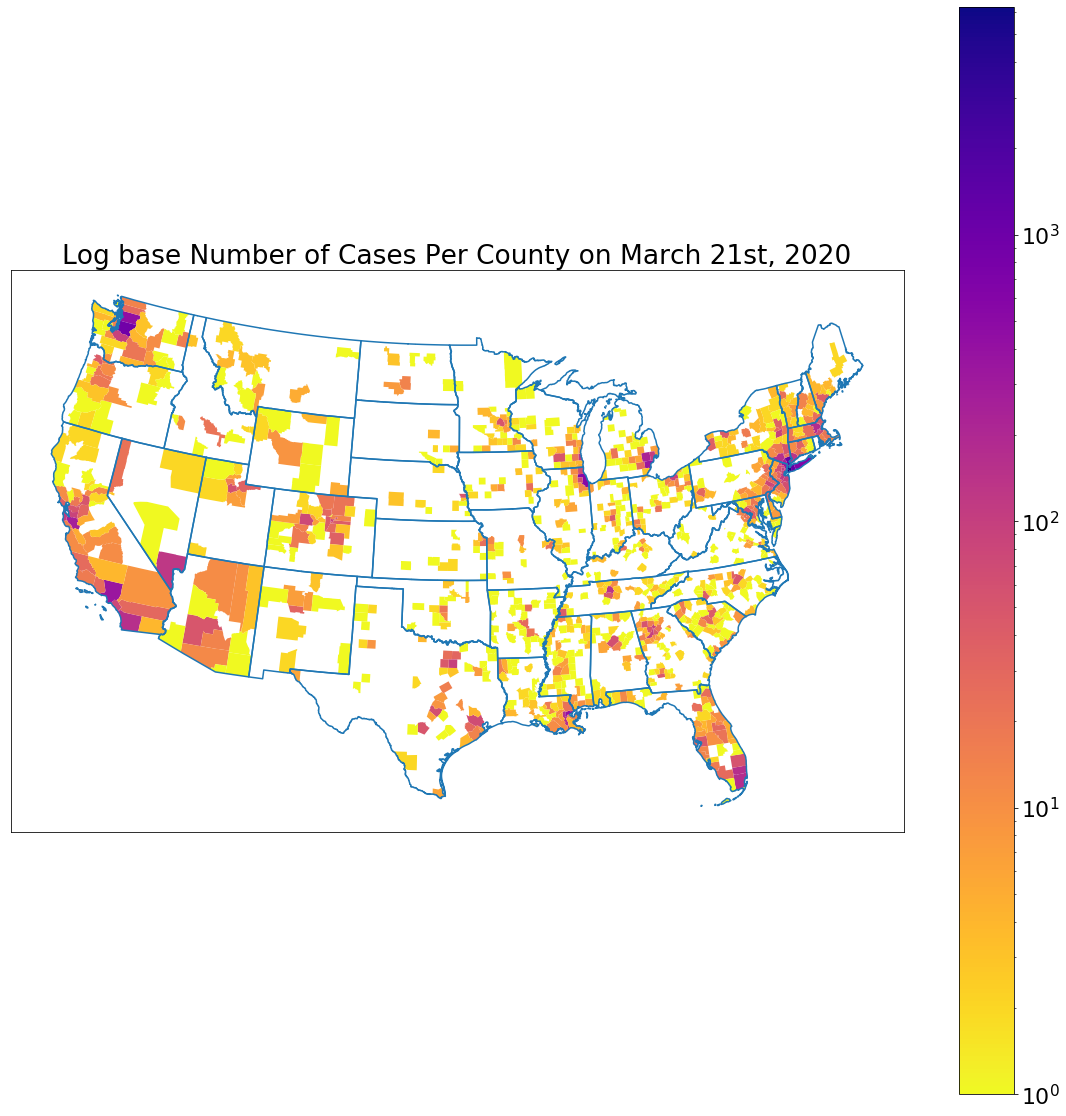

In [15]:
#state boundaries
base = states.boundary.plot()

#use data for scaling
data = nyt_county.loc['2020-03-21'].cases
#norm from data
norm = LogNorm(vmin=min(data), vmax=max(data))
#plotting with logarithm Norm
nyt_county.loc['2020-03-21'].plot(ax=base,column='cases',cmap='plasma_r',norm=norm,legend=True)
#lables
plt.xticks([])
plt.yticks([])
plt.title('Log base Number of Cases Per County on March 21st, 2020')
plt.show()

## Problem 5
In this problem, you will create an animation of the spread of Covid-19 through US counties from January 21, 2020 to June 21, 2020.
Use a log scale and a good colormap, and be sure that you're using the same norm and colorbar for the whole animation.
Use EPSG:5071 for the CRS.

As a reminder, below is a summary of what you will need in order to animate this map.
You may also find it helpful to refer to the animation section included with the Volume 4 lab manual. 

- Set up your figure and norm. Be sure to use the highest case count for your vmax so that the scale remains uniform.
- Write your update function. This should plot the cases from a given day.
- Set up your colorbar. Do this outside the update function to avoid adding a new colorbar each day.
- Create the animation and embed it.

In [16]:
#Set up figure and norm
fig, ax = plt.subplots(figsize=(10,7), ncols=1, nrows=1)
base = states.to_crs(5071).boundary.plot(ax=ax)
vmin, vmax = 1, nyt_county.cases.max()
norm = LogNorm(vmin=vmin, vmax=vmax)


def update(date):
    # Plot the cases from a single day
    mask = nyt_county.index == date
    nyt_county[mask].to_crs(5071).plot(ax=base, column='cases', cmap='plasma_r', norm=norm)
    plt.xticks([])
    plt.yticks([])
    plt.close()

#Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap='plasma_r'),
                    ax=ax, orientation='vertical', pad=0, label='Number of Cases')
plt.title("Covid US Timeline")

# Create date range to animate over
dates = pd.date_range(start=min(nyt_county.index), end=max(nyt_county.index))

#Create the animation
ani = animation.FuncAnimation(fig, update, frames=dates, interval=100)

In [17]:
ani.save('covid_ani.mp4')

In [18]:
HTML(ani.to_html5_video())